##  Проект "Прогнозирование оттока клиентов сети фитнес-центров"
## Оглавление:
* [Цель проекта](#intent)
* 1 [Предобработка данных](#1)
* 2 [Исследовательский анализ данных](#2)
    * 2.1 [Описание распределений признаков](#2.1)
    * 2.2 [Средние значения признаков](#2.2)
    * 2.3 [Столбчатые гистограммы и распределения признаков](#2.3)
    * 2.4 [Матрица корреляций признаков](#2.4)
* 3 [Модель прогнозирования оттока клиентов](#3)
* 4 [Кластеризация клиентов](#4)
    * 4.1 [Дендрограмма](#4.1)
    * 4.2 [Модель кластеризации](#4.2)
    * 4.3 [Распределение признаков по кластерам](#4.3)
* [Вывод](#conclusion)

## Цель проекта:<a id="intent"></a>
Провести анализ клиентских анкет сети фитнес-центров и дать рекомендации по удержанию клиентов.

Для этого необходимо:
> - Научиться прогнозировать вероятность оттока для каждого клиента;
> - Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
> - Проанализировать основные признаки, наиболее сильно влияющие на отток;
> - Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

## 1 Предобработка данных<a id="1"></a>
Загрузим данные, сохраним их в файле gym_churn и выведем первые строки датасета и информацию о нем.

In [20]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [21]:
gym_churn = pd.read_csv('d:/files/praktikum_csv_files/gym_churn.csv')
gym_churn.info()
gym_churn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


В датасете нет пропусков, тип данных корректный, типы признаков числовые и категориальные (бинарные). Целевая переменная 'churn' - бинарная величина. Проверим таблицу на дубликаты.

In [22]:
gym_churn.duplicated().sum()

0

Дубликатов в таблице нет. Для удобства работы с колонками приведем их название к единому регистру.

In [23]:
gym_churn.columns = gym_churn.columns.str.lower()
gym_churn.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## 2 Исследовательский анализ данных<a id="2"></a>
### 2.1 Описание распределений признаков<a id="2.1"></a>
Выведем описание распределений числовых признаков.

In [24]:
features_num = (['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 
                 'avg_class_frequency_total', 'avg_class_frequency_current_month'])
features_cat = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']

In [25]:
gym_churn.drop(features_cat, axis=1).describe()

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,4.681250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052
std,4.549706,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906
min,1.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,1.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,1.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,6.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,12.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783


Судя по медианным значениям, у половины клиентов фитнес-центров действующий абонемент на 1 месяц, также у половины клиентов срок абонемента истекает через один месяц (это не одни и те же клиенты). Средние значения для этих признаков не показательны, так как их искажают полугодовые и годовые абонементы.

Средний возраст клиентов - 29 лет. А клиентами этой сети они стали в среднем 3-4 месяца назад. В фитнес-центр эти клиенты ходят в среднем чуть меньше двух раз в неделю и на дополнительные услуги потратили в среднем около 147 условных единиц. Эти данные близки к медианным значениям.

Вероятно именно клиенты с минимальным сроком абонемента чаще всего не возвращаются и, соответственно, являются основной целью удержания.

### 2.2 Средние значения признаков<a id="2.2"></a>
Выведем средние значения признаков, сгруппировав данные по тем, кто ушел в отток и тем, кто продолжает посещать фитнес-центры. Для бинарных признаков среднее будет показывать долю клиентов с классом '1'.

In [26]:
gym_churn.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Предположительно на отток влияет место где находится фитнес-центр: среди ушедших клиентов доля тех, кто не живет и не работает в районе расположения фитнес-центра, больше, чем среди оставшихся клиентов (23 % и 13 % соответственно). 

Также, вероятно, влияет и стоимость абонемента: среди ушедших клиентов партнерских скидок или промокода от друга не было у 64 % и 81 % соответственно. Среди оставшихся клиентов без партнерской скидки за абонемент заплатили 46 % и 64 % без промокода от друга.

Возможно заниматься на групповых занятиях клиентам комфортнее, чем самостоятельно, так как среди ушедших клиентов такие занятия посещали 27 %, а среди оставшихся - 46 %.

Пол клиента на отток скорее всего не влияет, так как и среди ушедших и среди оставшихся клиентов соотношение мужчин и женщин близко к равному. Также, вероятно, не влияет и средний возраст: действующим клиентам в среднем почти 30 лет, а ушедшим - почти 27.

В среднем у оставшихся клиентов больше общий срок абонемента и срок до его окончания - 5.8 и 5.3 месяца соответственно против 1.7 и 1.6 месяца у ушедших клиентов. Возможно, что абонемент на длительный срок покупают более ответственные люди, и наоборот - более дорогой абонемент морально тяжелее забросить.

В среднем клиент, продолжающий посещать фитнес-центр, является клиентом чуть меньше 5 месяцев и занимается 2 раза в неделю, а ушедший стал клиентом меньше одного месяца назад с 1-1.5 занятием в неделю. Соответственно и трат на дополнительные услуги у действующих клиентов на треть больше.

И действующие и ушедшие клиенты в 90 % случаев указывают свои номера телефонов, что можно использовать для персональных предложений.

### 2.3 Столбчатые гистограммы и распределения признаков<a id="2.3"></a>
Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл и тех, кто остался.

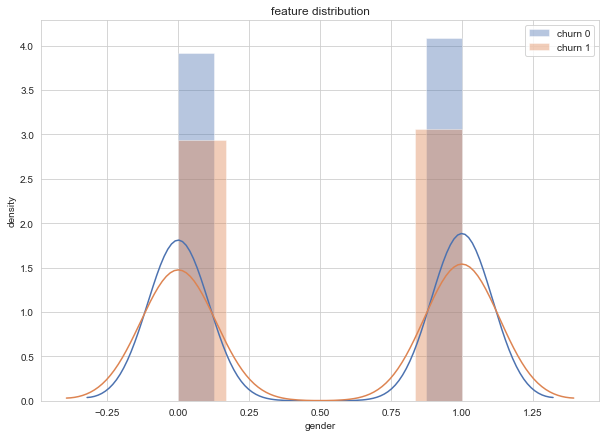

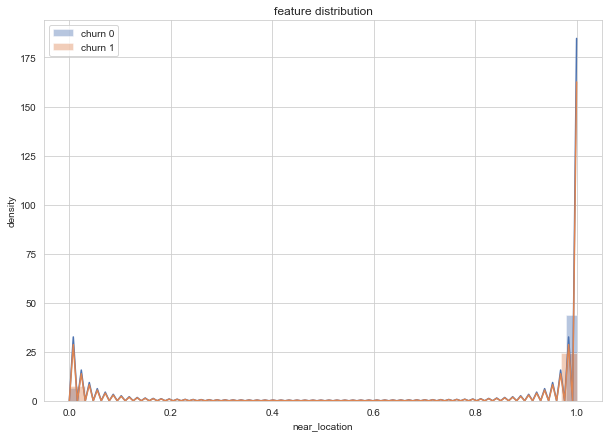

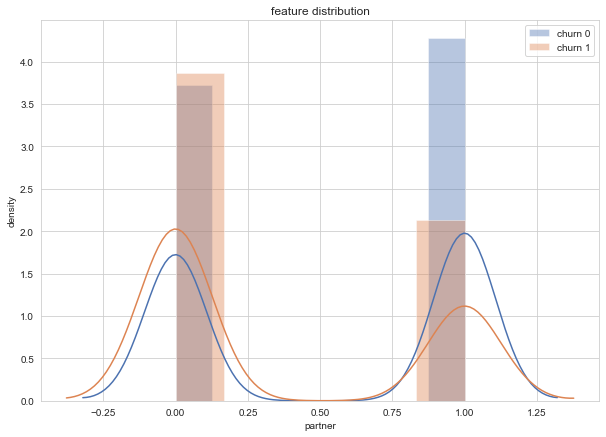

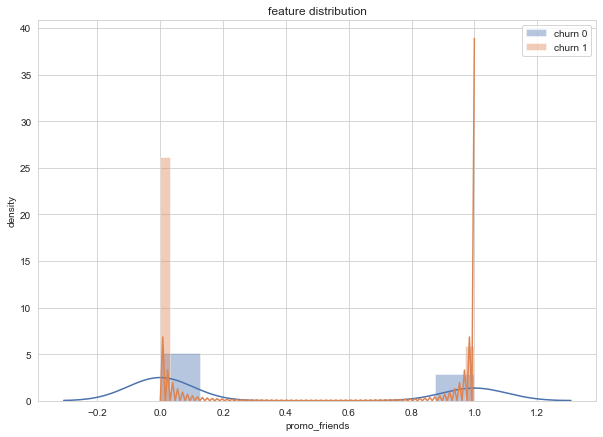

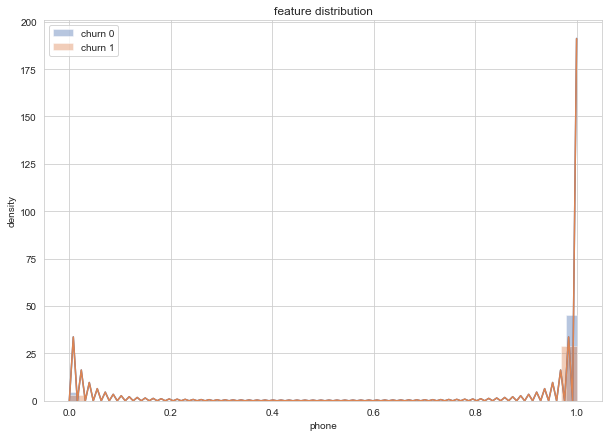

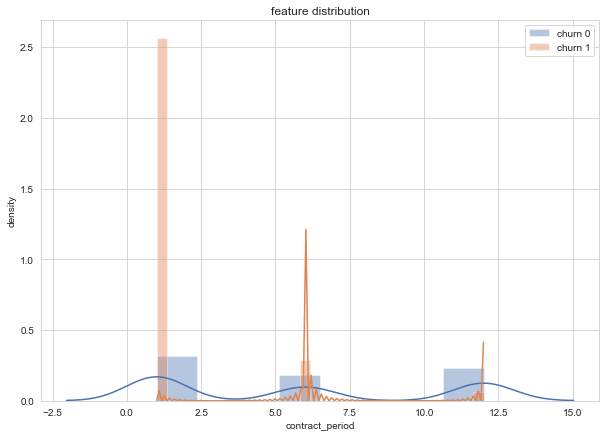

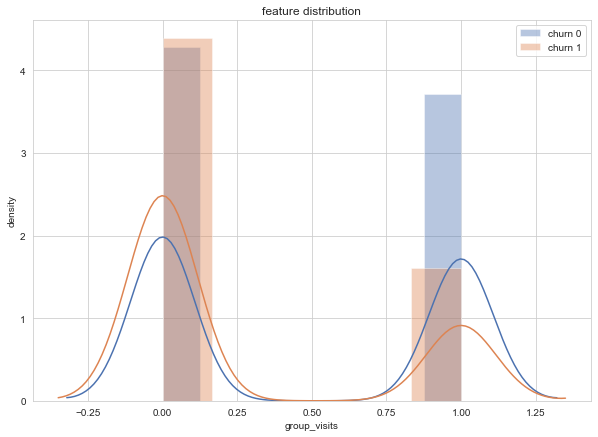

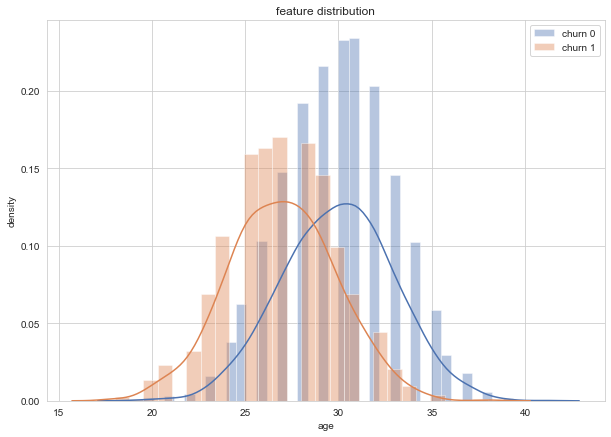

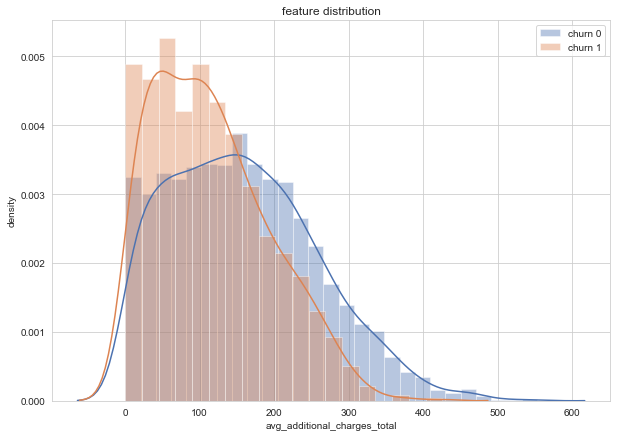

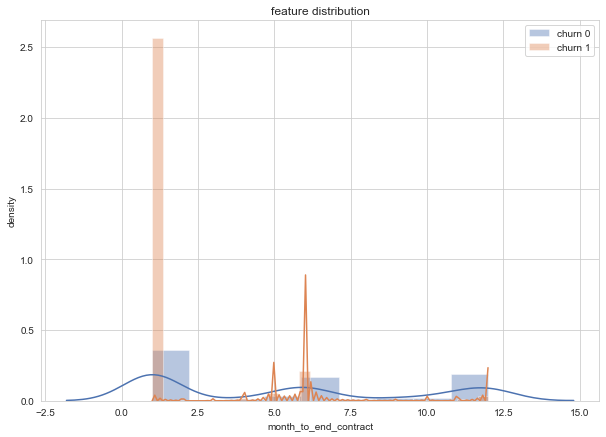

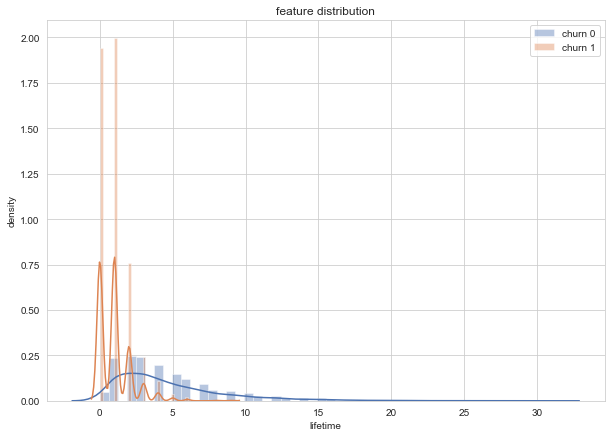

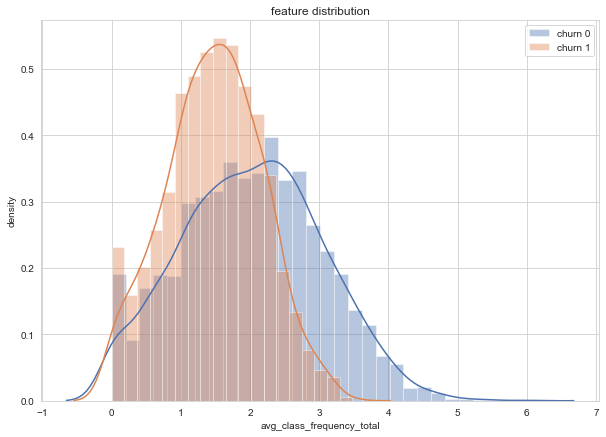

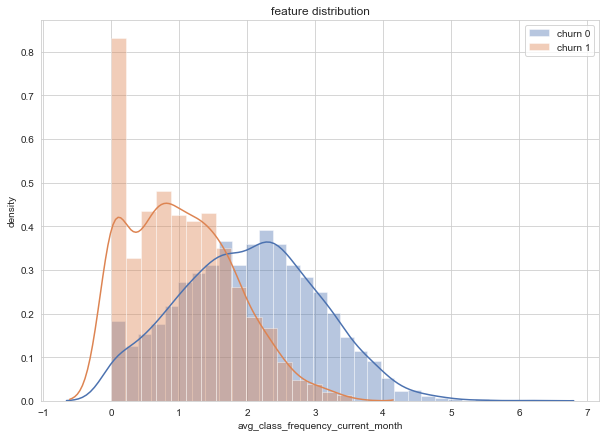

In [27]:
for feat in gym_churn.drop('churn', axis=1).columns:
    sns.set_palette('deep')
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.distplot(gym_churn[gym_churn['churn'] == 0][feat])
    sns.distplot(gym_churn[gym_churn['churn'] == 1][feat])
    plt.title('feature distribution')
    plt.legend(('churn 0', 'churn 1'))
    plt.xlabel(feat)
    plt.ylabel('density')
    plt.show()

Графики соотносятся с предположениями, указанными выше. Графики бинарных признаков в данном случае менее показательны. Для ушедших в отток клиентов, распределения признаков, связанные со временем, более подвержены выбросам около нуля на графике. Вероятно это связано с тем, что большое количество клиентов уходят, после нескольких посещений фитнес-центра.

### 2.4 Матрица корреляций признаков<a id="2.4"></a>
Выведем матрицу корреляций.

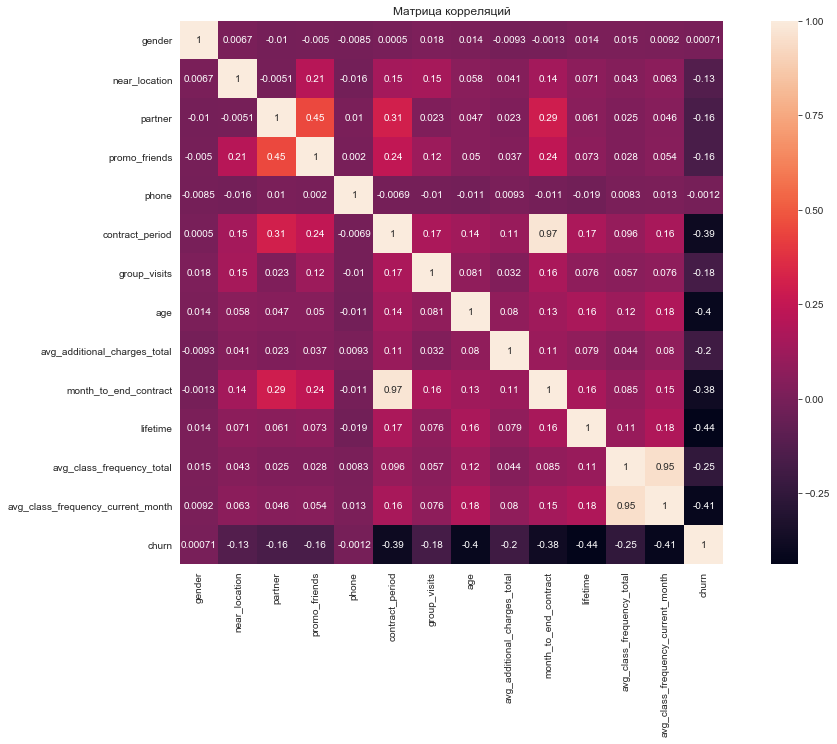

In [28]:
cm = gym_churn.corr()
fig, ax = plt.subplots(figsize=(17, 10))
sns.heatmap(cm, annot = True, square=True)
ax.set_ylim(14, 0)
ax.set_title('Матрица корреляций')
plt.show()

Сильных и прямых корреляций у целевой переменной с признаками нет, с большинством признаков корреляция даже отрицательная. То есть к гипотезам, указанным ранее, матрица корреляций ничего не добавляет. Можно отметить две пары признаков коррелирующих между собой: длительность текущего действующего абонемента (contract_period) с сроком до окончания текущего действующего абонемента (month_to_end_contract) и средняя частота посещений в неделю за все время с начала действия абонемента (avg_class_frequency_total) с средней частотой посещений в неделю за предыдущий месяц (avg_class_frequency_current_month). При обучении модели не будем использовать признаки month_to_end_contract и avg_class_frequency_current_month, чтобы модель работала корректно.

## 3 Модель прогнозирования оттока клиентов<a id="3"></a>
Построим модель бинарной классификации клиентов, где целевым признаком будет факт оттока клиента в следующем месяце. Сначала разобъем признаки и целевую переменную на обучающую и валидационную выборку в соотношении 80 к 20.

In [29]:
X = gym_churn.drop(columns = ['churn', 'month_to_end_contract', 'avg_class_frequency_current_month'])
y = gym_churn['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

Сначала обучим модель на train-выборке логистической регрессией и рассчитаем метрики accuracy, precision и recall для этой модели на валидационной выборке.

In [30]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)[:,1]
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_precision = precision_score(y_test, lr_predictions)
lr_recall = recall_score(y_test, lr_predictions)

D:\Program Files\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Теперь то же самое проделаем для модели, обученной случайным лесом.

In [31]:
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)

D:\Program Files\Anaconda\envs\practicum\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Выведем и сравним метрики каждой модели.

In [32]:
display('Accuracy логистическая регрессия {:.2f}, Accuracy случайный лес {:.2f}'.format(lr_accuracy, rf_accuracy))
display('Precision логистическая регрессия {:.2f}, Precision случайный лес {:.2f}'.format(lr_precision, rf_precision))
display('Recall логистическая регрессия {:.2f}, Recall случайный лес {:.2f}'.format(lr_recall, rf_recall))

'Accuracy логистическая регрессия 0.88, Accuracy случайный лес 0.88'

'Precision логистическая регрессия 0.76, Precision случайный лес 0.77'

'Recall логистическая регрессия 0.77, Recall случайный лес 0.73'

В доле правильных ответов, и в точности обе модели почти равны, а в полноте лучше всего себя показала модель, обученная алгоритмом логистической регрессии. А значит именно эту модель необходимо использовать для выявления клиентов, которые потенциально могут уйти в отток, чтобы начинать работать с ними на удержание.

## 4 Кластеризация клиентов<a id="4"></a>
### 4.1 Дендрограмма<a id="4.1"></a>
Чтобы отнести клиента к тому или иному кластеру необходимо задать количество этих кластеров. Для определения количества кластеров приведем признаки к одному масштабу стандартизацией, вычислим матрицу расстояний между всеми признаками (в ячейках матрицы будет попарное расстояние между двумя признаками). Эту матрицу визуализируем на дендограмме. 

In [33]:
sc = StandardScaler()
X_st = sc.fit_transform(gym_churn)
linked = linkage(X_st, method = 'ward')

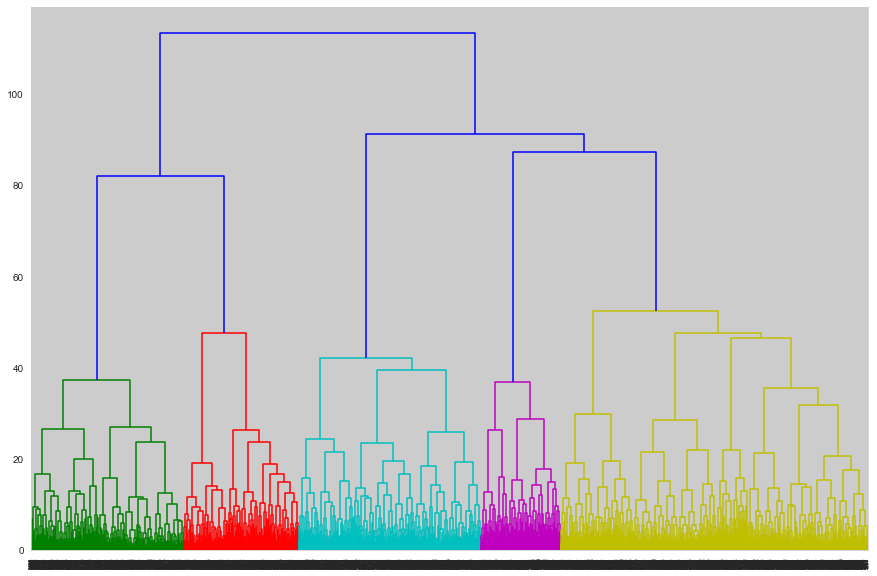

In [34]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Предложенное оптимальное число кластеров 5 — пять разных цветов на графике.

### 4.2 Модель кластеризации<a id="4.2"></a>
Обучим модель алгоритмом K-Means с определенным ранее количеством кластеров на стандартизированных признаках. Создадим в датасете новый столбец с указанием индекса кластера для каждого наблюдения.

In [35]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(X_st)
gym_churn['cluster_km'] = labels

Выведем средние значения признаков для кластеров.

In [36]:
gym_churn.drop('churn', axis=1).groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
cluster_km,,,,,,,,,,,,,
0,0.503676,0.000000,0.459559,0.075368,0.917279,2.069853,0.211397,28.522059,132.741216,1.950368,2.757353,1.706629,1.515890
1,0.492829,0.936115,0.764016,0.534550,0.919166,10.447197,0.516297,29.962190,161.853561,9.477184,4.833116,2.788103,2.786919
2,0.507917,1.000000,0.323995,0.213155,0.903776,1.546894,0.287454,26.926918,113.173051,1.500609,1.031669,1.449720,1.037592
3,0.521186,0.996610,0.282203,0.208475,0.904237,1.882203,0.452542,30.237288,157.988625,1.794915,4.923729,2.203432,2.207359
4,0.518895,0.968023,0.744186,0.526163,0.873547,8.859012,0.534884,29.728198,162.907495,8.155523,4.411337,0.957744,0.943967


По ряду признаков выделяется кластер 2:
> - В нем наименьшие средний срок абонемента и, соответственно, средний срок до окончания абонемента;
> - В этом кластере наименьший средний возраст клиентов;
> - Клиенты этого кластера меньше других в среднем тратят на дополнительные услуги;
> - Клиенты этого кластера в среднем меньше всего времени являются клиентами сети.

### 4.3 Распределение признаков по кластерам<a id="4.3"></a>
Построим соответствующие графики для каждого признака с разделением по кластерам.

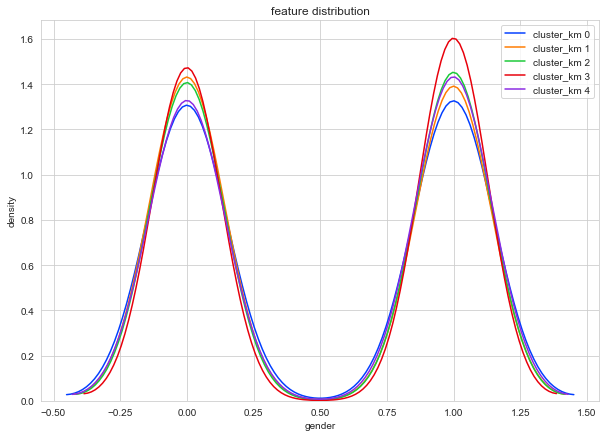

D:\Program Files\Anaconda\envs\practicum\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
D:\Program Files\Anaconda\envs\practicum\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


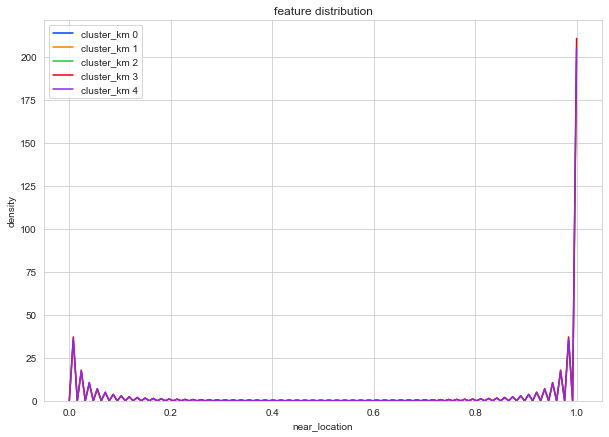

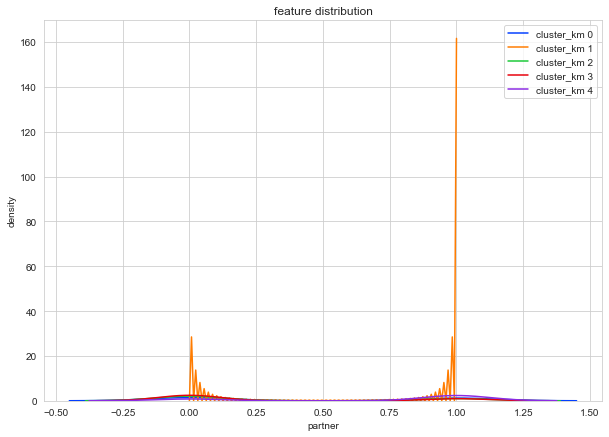

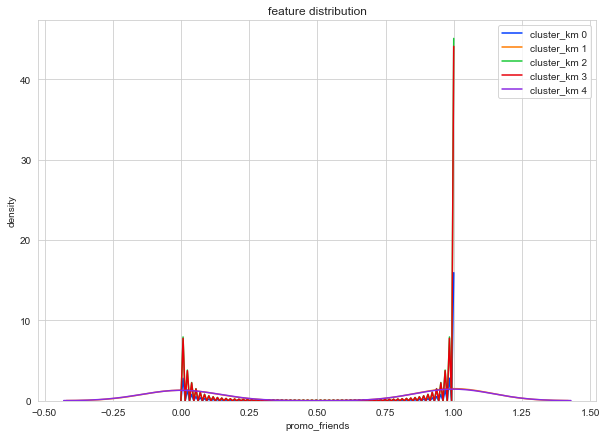

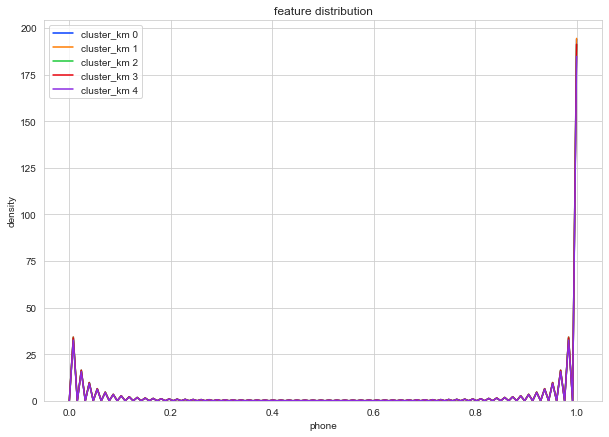

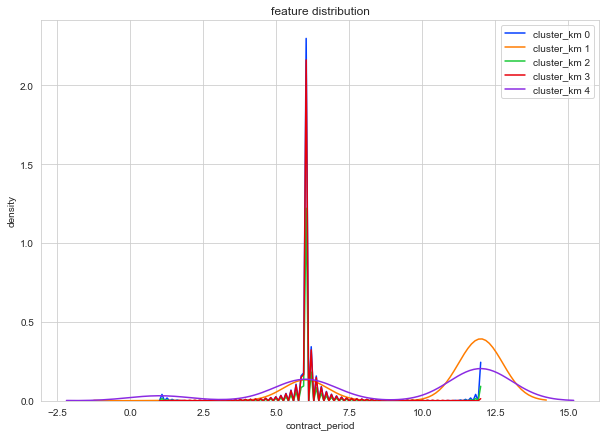

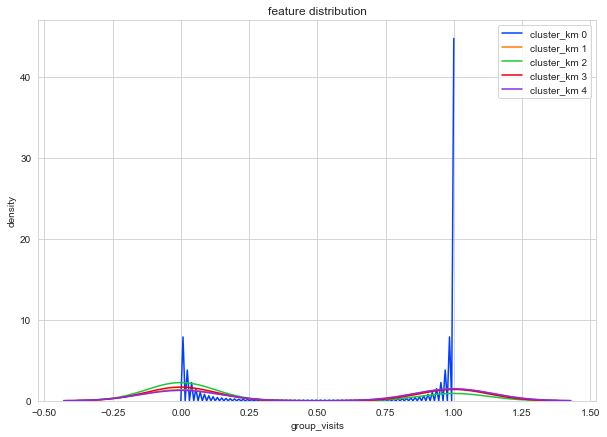

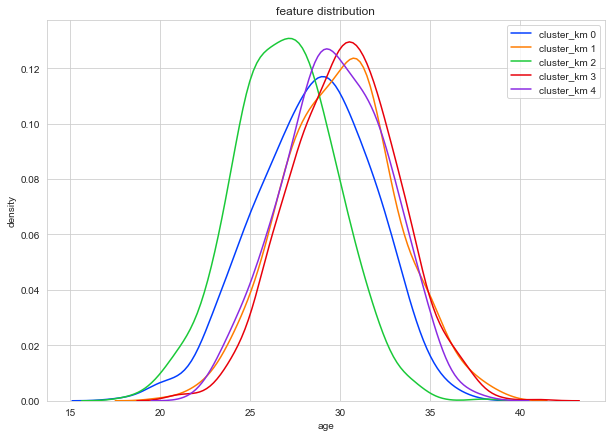

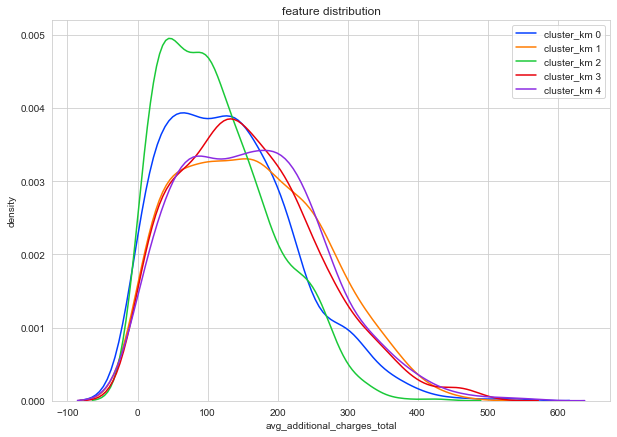

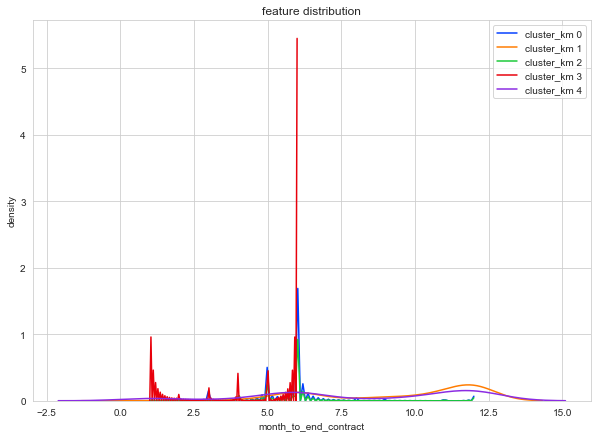

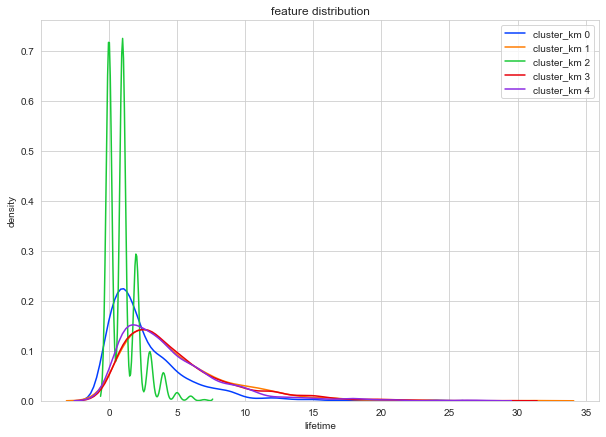

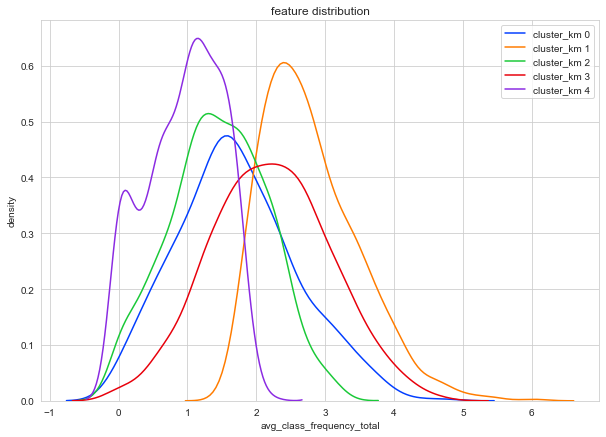

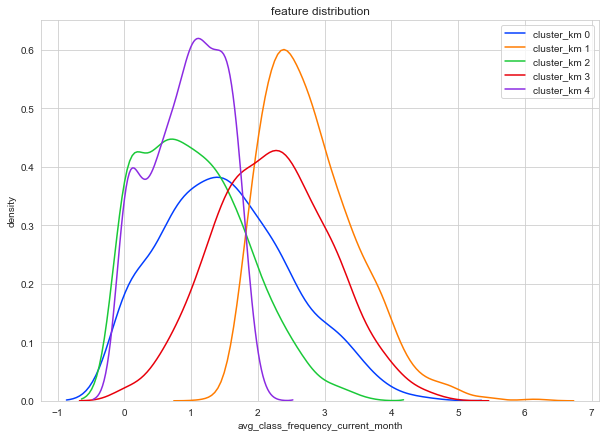

In [37]:
for feat in gym_churn.drop(['churn', 'cluster_km'], axis=1).columns:
    sns.set_palette('bright')
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.kdeplot(gym_churn[gym_churn['cluster_km'] == 0][feat])
    sns.kdeplot(gym_churn[gym_churn['cluster_km'] == 1][feat])
    sns.kdeplot(gym_churn[gym_churn['cluster_km'] == 2][feat])
    sns.kdeplot(gym_churn[gym_churn['cluster_km'] == 3][feat])
    sns.kdeplot(gym_churn[gym_churn['cluster_km'] == 4][feat])
    plt.title('feature distribution')
    plt.legend(('cluster_km 0', 'cluster_km 1', 'cluster_km 2', 'cluster_km 3', 'cluster_km 4'))
    plt.xlabel(feat)
    plt.ylabel('density')
    plt.show()

На 3 графиках распределений для признаков выделяются графики для кластера 2. По ним видно, что у клиенты этого кластера моложе клиентов из других кластеров, меньше тратят на дополнительные услуги, наименьшее время являются клиентами фитнес-центра.

Чтобы проверить эти догадки для каждого полученного кластера выведем долю оттока.

In [38]:
gym_churn.groupby('cluster_km')['churn'].mean().sort_values(ascending=False)

cluster_km
2    0.961023
0    0.450368
4    0.024709
1    0.007823
3    0.003390
Name: churn, dtype: float64

Кластеризация сработала корректно, выделяясь по признакам, кластер 2 имеет и самую высокую долю оттока клиентов - 96 %. У следующего за ним кластера 0 доля оттока 45 %. А самыми лояльными являются клиенты кластеров 3, 1 и 4, где доля оттока составляет соответственно 0.3, 0.8 и 2.5 %.

## Вывод<a id="conclusion"></a>
В проекте были изучены данные анкет клиентов сети фитнес-центров. При анализе признаков были выдвинуты следующие гипотезы о том, что характерно для уходящих клиентов:
> - Расположение фитнес-центра не в районе проживания или работы;
> - Отсутствие скидок при покупке абонемента;
> - Не посещал групповые занятия;
> - Маленькие общий срок абонемента и срок до его окончания;
> - Маленький срок с момента первого обращения в фитнес-центр;
> - Количество посещений за весь срок и за предыдущий месяц меньше 2 раз в неделю;
> - Небольшие траты на дополнительные услуги.

Столбчатые диаграммы и распределения для признаков ушедших клиентов и для клиентов действующих эти гипотезы не опровергли. Матрица корреляций признаков не показала большой зависимости оттока от каждого признака по отдельности.

Для прогнозирования оттока клиентов на train-выборке признаков были обучены две модели: логистическая регрессия и случайный лес. Для сравнения предсказаний моделей на валидационной выборке были рассчитаны три метрики: доля правильных ответов (accuracy), точность (precision) и полнота (recall). По всем трем метрикам лучше всего себя показала логистическая регрессия. А значит целесообразнее использовать именно ее для определения клиентов, которые могут уйти в отток.

Также для определения таких клиентов была применена кластеризация. Чтобы определить количество кластеров признаки были стандартизированы, по ним рассчитана матрица расстояний между всеми признака. После этого матрица была визуализирована в дендрограмме, которая показала 5 оптимальным количеством кластеров. С этим количеством кластеров была обучена модель K-Means, которая для каждого наблюдения в датасете указала принадлежность к соответствующему кластеру.

По усредненным признакам каждого кластера, а также по графикам распределений признаков по кластерам выделялся кластер 2. Для него работали выдвинутые ранее гипотезы:
> - Наименьший средний срок абонемента и средний срок до окончания абонемента;
> - Небольшие траты на дополнительные услуги;
> - Маленький срок с момента первого обращения в фитнес-центр.

И добавился признак наименьшего среднего возраста клиентов, которые уходят в отток. Вычисление доли ушедших клиентов для каждого кластера подтвердило, что в кластере 2 ушло больше всего клиентов - 96 %. А значит кластеризация сработала корректно.

Исходя из признаков целевой группы клиентов стоит рассмотреть следующие действия:
> - Разработка программы лояльности, которая бы предлагала клиенту скидки на абонемент с большей длительностью и скидки на дополнительные услуги фитнес-центра;
> - Опросы клиентов для оценки удовлетворенности сервисом;
> - Опрос ушедших клиентов о причинах такого решения и персональные предложения для их возвращения.